In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
# Use a CNN that has undergone brief transfer learning to produce a dataset with images of unambiguous class.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [63]:
# These are all the package we'll use
from fastai.imports import *
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import time
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import glob
import matplotlib.image as mpimg
import cv2

In [61]:
def isdaytime(image):
    """
    Returns whether NYSM image was taken in day (color) or night (grayscale) mode.
    :rtype: boolean
    """
    return not (image == cv2.cvtColor(image, cv2.COLOR_RGB2BGR)).all()

In [3]:
#check to make sure you have access to a GPU
# torch.cuda.is_available()
# torch.backends.cudnn.enabled
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


2021-12-30 02:10:23.981990: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-30 02:10:25.440039: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 30995 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2021-12-30 02:10:25.454889: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 30995 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:06:00.0, compute capability: 7.0


In [4]:
model = keras.models.load_model('./models/1229_relabeler')

2021-12-30 02:10:25.895793: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30995 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:06:00.0, compute capability: 7.0


In [6]:
## change below path to /tf/username/model_img/ALL
PATH = '/home/jpan/visibility/model_img/0721_DS1alt/' #GFAL
data_dir = pathlib.Path(PATH)
#resize image 
# sz=224
# List containing the entries in the directory given by PATH
os.listdir(PATH)
image_count = len(list(data_dir.glob('*/*.jpg')))

#set batch size and original image dimensions
batch_size = 16 #TODO figure out what the OOM issue is
img_height = 720
img_width = 1280

#total image count
print(image_count)

29499


In [11]:
def read_dirs(path, folder):
    labels, filenames, all_labels = [], [], []
    full_path = os.path.join(path, folder)
    for label in sorted(os.listdir(full_path)):
        if label != '.ipynb_checkpoints': #not in ('.ipynb_checkpoints'):
            all_labels.append(label)
            for fname in os.listdir(os.path.join(full_path, label)):
                filenames.append(os.path.join(folder, label, fname))
                labels.append(label)
    return filenames, labels, all_labels

In [ ]:
#run rm -rf .ipynb_checkpoints to get correct class names
%cd /tf/visibility/model_img/0721_DS1alt/
%rm -rf .ipynb_checkpoints

In [12]:
def prep_fn(img):
    """
    Convert pixel values from [0, 255] to [-1, 1]
    """
    img = img.astype(np.float32) / 255.0
    img = (img - 0.5) * 2
    return img

In [13]:
#set up generators for training and validation data

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    zoom_range=0.1,
    preprocessing_function=prep_fn)
#train_datagen.fit(np.stack(list(train_ds)))
train_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=prep_fn, validation_split=0.2)
val_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=prep_fn, validation_split=0.2)

gen_kwargs = dict(seed=123, batch_size=batch_size, class_mode='categorical',
                  target_size=(img_height, img_width), classes = {'0-1': 0, '2': 1, '3': 2, '4': 3})
train_gen = train_datagen.flow_from_directory(
    data_dir,
    subset="training",
    **gen_kwargs
    )
val_gen = val_datagen.flow_from_directory(
    data_dir,
    subset="validation",
    **gen_kwargs)

Found 23600 images belonging to 4 classes.
Found 5899 images belonging to 4 classes.


In [14]:
#comment out if doing cropping
#del(train_ds.class_names[0])
#del(val_ds.class_names[0])
class_names = [key for key in train_gen.class_indices]
print(class_names)

['0-1', '2', '3', '4']


In [ ]:
#display a few images for a sanity check (all labels should be correct, and no imgs should be corrupted)
plt.figure(figsize=(10, 10))
images, labels = next(iter(train_gen))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] + 1) / 2)
    plt.title(class_names[np.where(labels[i] == 1)[0][0]])
    plt.axis("off")

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = images.shape[1:]
base_model = tf.keras.applications.resnet_v2.ResNet101V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_gen)) #batch size of 128 is too large for memory. Is there any way to get image_batch from the datagens? W/o using datagen.fit()?
feature_batch = base_model(image_batch)
print(feature_batch.shape)

[[0.14717592 0.15344805 0.2805456  0.41883045]]
This image most likely belongs to 4 with a 41.88 percent confidence.


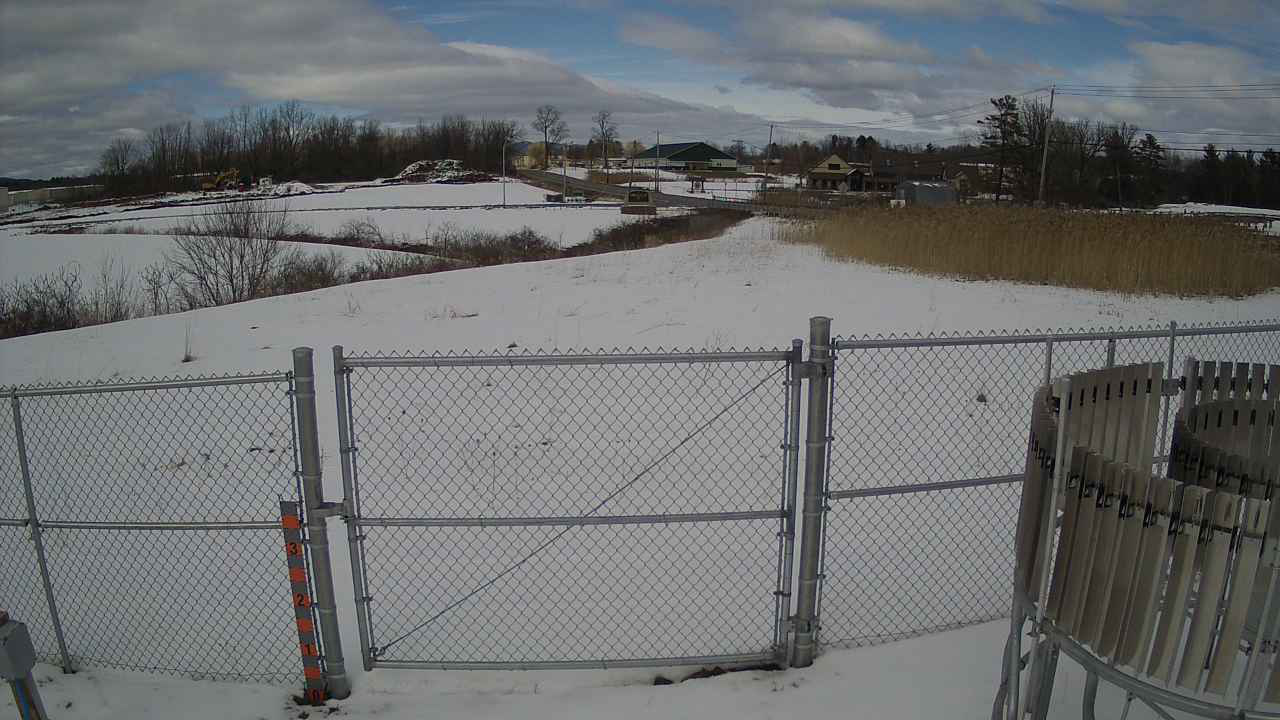

In [39]:
import glob

samples = ['/home/jpan/NYSM/archive/nysm/cam_photos/2017/03/14/GFAL/20170314T150004_GFAL.jpg',
           '/home/jpan/NYSM/archive/nysm/cam_photos/2019/05/05/BELD/20190505T135027_BELD.jpg',
           '/home/jpan/NYSM/archive/nysm/cam_photos/2018/03/03/SCIP/20180303T125029_SCIP.jpg',
           '/home/jpan/NYSM/archive/nysm/cam_photos/2019/05/15/GFAL/20190515T130527_GFAL.jpg',  #perfect vis with blue sky
           '/home/jpan/NYSM/archive/nysm/cam_photos/2020/09/09/BATA/20200909T120026_BATA.jpg', #thick fog
           '/home/jpan/NYSM/archive/nysm/cam_photos/2020/12/17/BATA/20201217T220027_BATA.jpg', #snow on the ground
           '/home/jpan/NYSM/archive/nysm/cam_photos/2020/11/17/BATA/20201117T180026_BATA.jpg', #light fog
           '/home/jpan/NYSM/archive/nysm/cam_photos/2020/09/24/BATA/20200924T180027_BATA.jpg', #perfect vis with hazy sky
           '/home/jpan/NYSM/archive/nysm/cam_photos/2019/01/30/MANH/20190130T203528_MANH.jpg', #'/home/jpan/NYSM/archive/nysm/cam_photos/2019/01/30/QUEE/20190130T204528_QUEE.jpg',
           '/home/jpan/NYSM/archive/nysm/cam_photos/2019/01/30/MANH/20190130T192527_MANH.jpg', #'/home/jpan/NYSM/archive/nysm/cam_photos/2019/01/30/QUEE/20190130T190527_QUEE.jpg',
           '/home/jpan/NYSM/archive/nysm/cam_photos/2021/02/03/GROT/20210203T112533_GROT.jpg',
           '/home/jpan/NYSM/archive/nysm/cam_photos/2018/07/16/PENN/20180716T083028_PENN.jpg']
new_img_path = '/home/jpan/NYSM/archive/nysm/cam_photos/2018/03/11/GFAL/20180311T180026_GFAL.jpg' #'/home/jpan/NYSM/archive/nysm/cam_photos/2021/02/05/BATA/20210205T050026_BATA.jpg'

'''samples = ['/home/jpan/NYSM/archive/nysm/cam_photos/2021/02/02/GABR/20210202T190034_GABR.jpg',
           '/home/jpan/NYSM/archive/nysm/cam_photos/2021/04/14/GABR/20210414T123531_GABR.jpg',
           '/home/jpan/NYSM/archive/nysm/cam_photos/2021/03/09/GABR/20210309T132036_GABR.jpg',
           '/home/jpan/NYSM/archive/nysm/cam_photos/2021/02/02/GABR/20210202T211033_GABR.jpg',
           '/home/jpan/NYSM/archive/nysm/cam_photos/2018/03/02/GABR/20180302T150526_GABR.jpg']'''

'''samples = ['/tf/visibility/model_img/0709_overfit/excellent/20210314T130034_GABR.jpg',
           '/tf/visibility/model_img/0709_overfit/excellent/20210314T130034_GABR.jpg',
           '/tf/visibility/model_img/0709_overfit/fair/20210314T180034_GABR.jpg',
           '/tf/visibility/model_img/0709_overfit/fair/20210314T190033_GABR.jpg',
           '/tf/visibility/model_img/0709_overfit/fair/20210314T200033_GABR.jpg',
           '/tf/visibility/model_img/0709_overfit/fair/20210314T210034_GABR.jpg',
           '/tf/visibility/model_img/0709_overfit/reduced/20210314T110033_GABR.jpg',
           '/tf/visibility/model_img/0709_overfit/reduced/20210314T120035_GABR.jpg',
           '/tf/visibility/model_img/0709_overfit/reduced/20210314T140033_GABR.jpg',
           '/tf/visibility/model_img/0709_overfit/reduced/20210314T170034_GABR.jpg',
           '/tf/visibility/model_img/0709_overfit/poor/20210314T150037_GABR.jpg',
           '/tf/visibility/model_img/0709_overfit/poor/20210314T160034_GABR.jpg'] #overfit test'''

#samples = glob.glob('/tf/visibility/model_img/0712_GABR_man/excellent/*.jpg')[:12]
#samples = glob.glob('/tf/visibility/model_img/0714_GABR_man/fair/*.jpg')[:12]
#samples = glob.glob('/tf/visibility/model_img/0714_GABR_man/reduced/*.jpg')[:12]
#samples = glob.glob('/tf/visibility/model_img/0712_GABR_man/poor/*.jpg')[:12]

img = keras.preprocessing.image.load_img(
    new_img_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = prep_fn(img_array)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = predictions[0] #tf.nn.softmax(predictions[0]) #TODO get rid of softmax since activation already has it
print(predictions)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(new_img_path)

In [17]:
def predict1(model, class_names, path = None, norm_img = None, img_height = 720, img_width = 1280):
    """
    Returns the predicted class and percent confidence for an image.
    
    :Parameters:
        model (tf model)
        class_names (list of str)
        path (str): path to image
        norm_img (array representation of image)
        
    :rtype: tuple (str, float, 1d np array)
    """
    img_array = None
    
    if path:
        img = keras.preprocessing.image.load_img(
        path, target_size=(img_height, img_width)
        )
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = prep_fn(img_array)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
    elif norm_img is not None:
        img_array = np.array([norm_img])
    else:
        raise TypeError('Need to pass either image path or image array as an argument.')

    predictions = model.predict(img_array)
    score = predictions[0]
    
    #print(predictions)
    return (class_names[np.argmax(score)], 100 * np.max(score), score)

    #TODO show all 4 probs

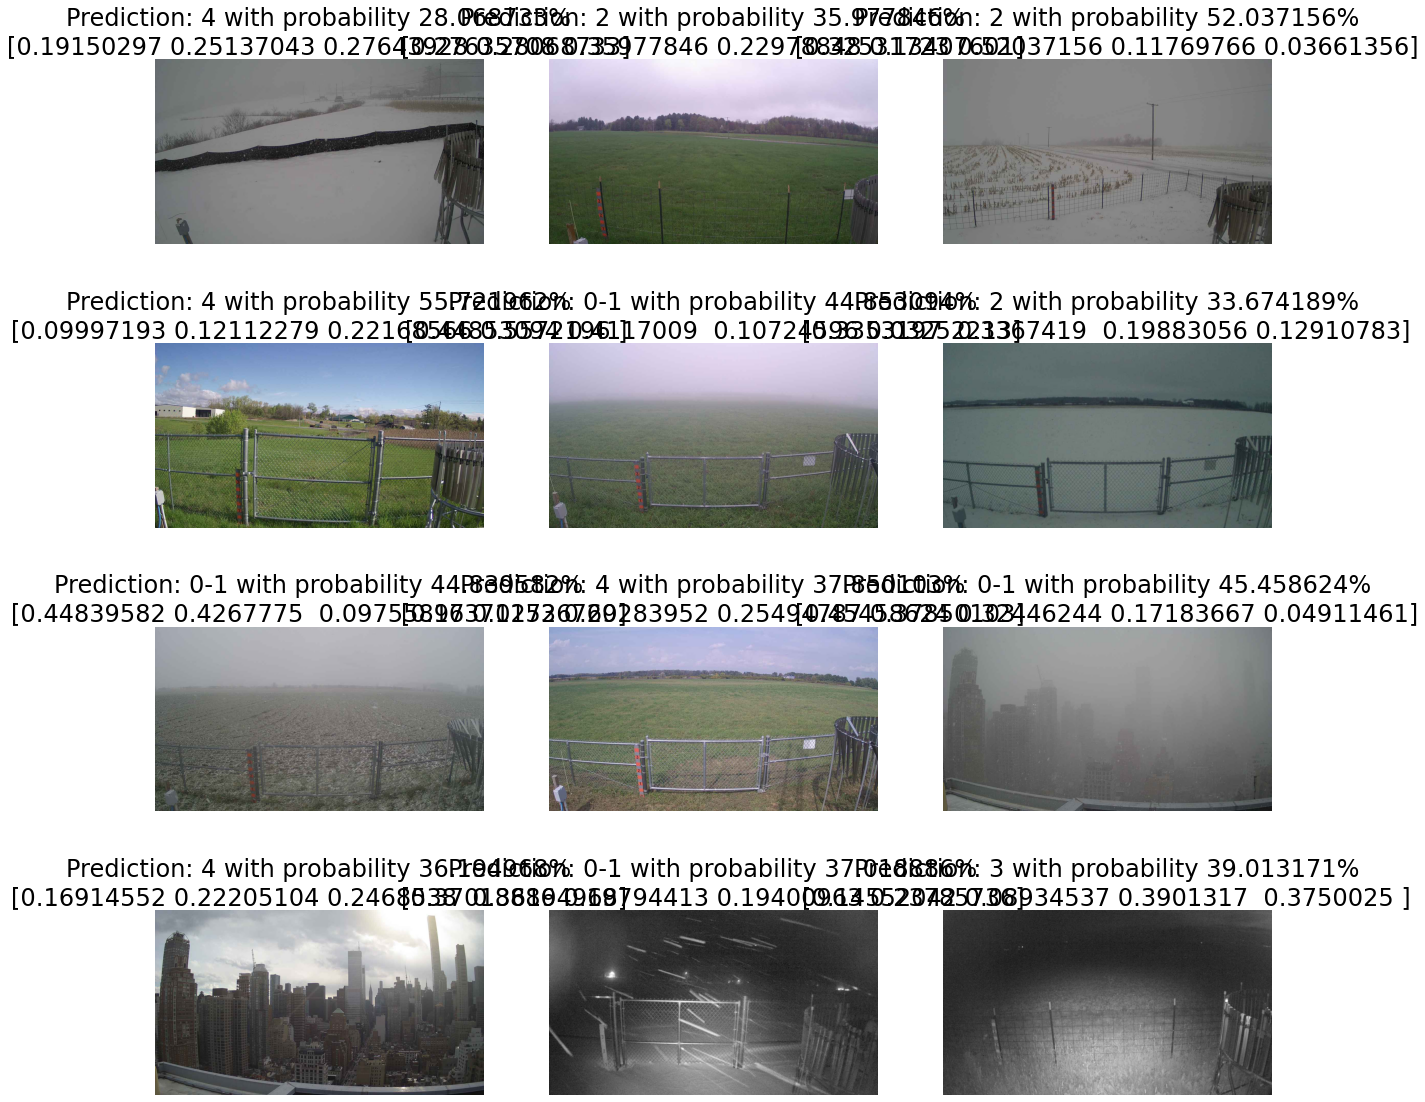

In [40]:
#display predictions for several images
plt.figure(figsize=(20, 20))
for i in range(len(samples)):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(plt.imread(samples[i]))
    plt.axis("off")
    plt.title("Prediction: %s with probability %f%%\n%s" % predict1(model, class_names, path=samples[i]))

In [19]:
## change below path to /tf/username/model_img/ALL
TEST_PATH = '/home/jpan/visibility/model_img/0721_DS2alt/' #GFAL
test_data_dir = pathlib.Path(TEST_PATH)
#resize image 
# sz=224
# List containing the entries in the directory given by PATH
os.listdir(PATH)
image_count = len(list(test_data_dir.glob('*/*.jpg')))

#total image count
print(image_count)

22545


In [20]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir,
  validation_split=.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  class_names = {'0-1': 0, '2': 1, '3': 2, '4': 3}) #{'poor': 0, 'reduced': 1, 'fair': 2, 'excellent': 3})

y_true = np.concatenate([y for x, y in test_ds], axis=0)

Found 22547 files belonging to 4 classes.
Using 2254 files for validation.


In [21]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
norm_test_ds = test_ds.map(lambda x, y: (rescale(x), y))

In [22]:
%%time
test_preds = model.predict(norm_test_ds)

CPU times: user 1min 58s, sys: 52.5 s, total: 2min 50s
Wall time: 1min 30s


In [105]:
y_pred = [np.argmax(out) for out in test_preds]
test_diffs = [y_pred[i] - y_true[i] for i in range(len(y_true))]
print('Test accuracy: %f%%' % (100 * sum([0 if diff else 1 for diff in test_diffs]) / len(test_diffs)))
prob_preds = np.array([np.max(out) for out in test_preds])
confident = np.where(prob_preds > 0.5)[0]
correct = np.where(np.array(test_diffs) == 0)[0]
conf_correct = np.intersect1d(confident, correct)
print(confident.shape[0], correct.shape[0], conf_correct.shape[0])

Test accuracy: 56.743567%
661 1279 573


In [98]:
print(len(test_ds.file_paths))

2254


/home/jpan/visibility/model_img/0721_DS2alt/4/20181002T040028_QUEE.jpg [0.08850436 0.129732   0.26314124 0.5186224 ] ('4', 44.24284100532532, array([0.12481573, 0.25728345, 0.17547235, 0.4424284 ], dtype=float32))
/home/jpan/visibility/model_img/0721_DS2alt/4/20170707T220030_QUEE.jpg [0.06051781 0.10467833 0.24496739 0.58983654] ('4', 61.08229160308838, array([0.06048892, 0.14653552, 0.1821527 , 0.6108229 ], dtype=float32))
/home/jpan/visibility/model_img/0721_DS2alt/3/20170623T140029_QUEE.jpg [0.05393821 0.08444284 0.25441065 0.6072083 ] ('2', 40.304601192474365, array([0.28863552, 0.403046  , 0.19865274, 0.10966571], dtype=float32))
/home/jpan/visibility/model_img/0721_DS2alt/4/20180815T230028_QUEE.jpg [0.06269577 0.13495588 0.13482499 0.6675233 ] ('3', 34.5516711473465, array([0.10583261, 0.21871658, 0.3455167 , 0.32993415], dtype=float32))
/home/jpan/visibility/model_img/0721_DS2alt/4/20170929T180029_QUEE.jpg [0.0679416  0.12145722 0.2858367  0.5247645 ] ('4', 43.99571418762207, ar

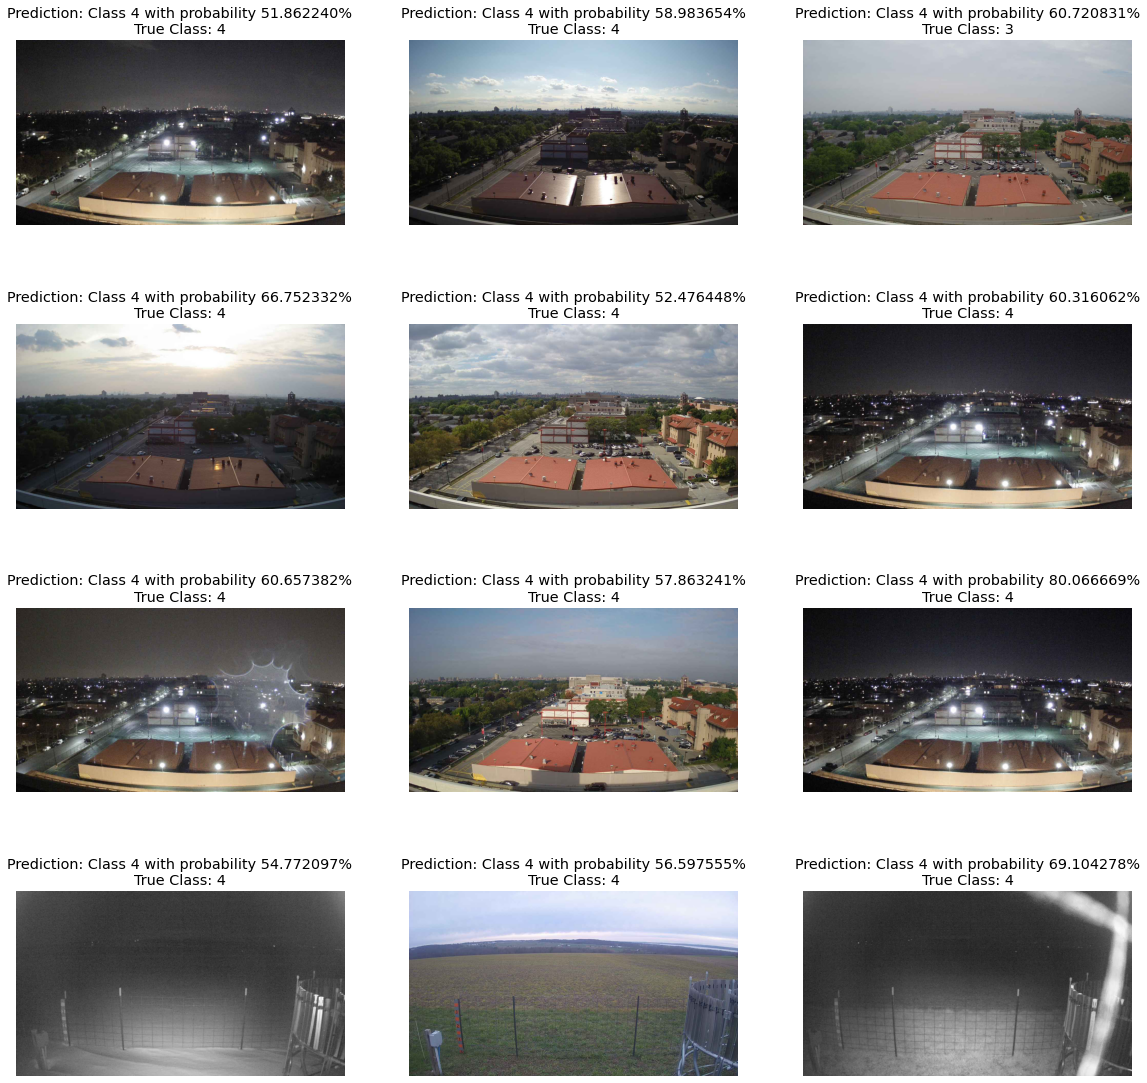

In [104]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)
plt.figure(figsize=(20, 20))
for i in range(12):
    selidx = np.random.choice(conf_correct)
    ax = plt.subplot(4, 3, i + 1)
    img_path = test_ds.file_paths[selidx]
    image = mpimg.imread(img_path)
    plt.imshow(image)
    plt.axis("off")
    plt.title("Prediction: Class %s with probability %f%%\nTrue Class: %s" %
             (class_names[y_pred[selidx]], prob_preds[selidx]*100, img_path.split('/')[-2]))
    print(img_path, test_preds[selidx], predict1(model, class_names, path=img_path))